<a href="https://colab.research.google.com/github/YeyoM/tensorflow_intro/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

The idea behind transfer learning is that we can take a neural network that has been trained on a large data set and apply its knowledge to a dataset that its never seen before.

When applying transfer learning with a model, what we would normally do is to change only the output layer of the model so that it can fit the requirements of the problem we are trying to solve.

![](https://drive.google.com/uc?export=view&id=1JTrl-zYAzQxs1tszWtsw45EmocIzQQAd)

To achieve this, we have to be sure that we dont change the pre-trained part of the model during the training process.

We do this by setting the variables of the pre-trained model to non-trainable, also called freezing the model.

![](https://drive.google.com/uc?export=view&id=1e85ksCdjFP6FiGlDNzNXTL7iahKsMrBi)

There are several neural networks that have a high accuracy, but tend to have thousands or even millions of parameters and with such a large number of parameters it takes a long time to train, to make predictions and needs a lot of computational power, so this models are not always the best option for building our models using transfer learning.

A most realistic cnn model we can use is called MobileNet, it is designed to minimize the amount of computational power you need to train and make predictions. Making this neural network awesome to run on mobile devices.





## How does this look in code?

Here are the key concepts that are going to be covered in the following blocks of this colab.

1. Use a TensorFlow Hub model for prediction.
2. Use a TensorFlow Hub model for Dogs vs. Cats dataset.
3. Do simple transfer learning with TensorFlow Hub.


## Imports

Just as before, we are going to import the libraries we need in addition to the tensorflow_hub

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import tensorflow_hub as hub

import matplotlib.pylab as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import numpy as np
import PIL.Image as Image

## Using Tensorflow Hub MobileNet

Before applying transfer learning in to the model that classifies dogs vs cats images, let's try the model we will use.

MobileNet model expects images of 224 x 224 px in 3 color channels (RGB).

MobileNet has been trained on the ImageNet dataset, which has 1000 different output classes for image classification.

### Download the classifier

In [2]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape = (IMAGE_RES, IMAGE_RES, 3))
])

### Test on a single image

This test image contains a man on a military uniform, which is a class contained in the ImageNet dataset classes.

61306/61306 [==============================] - 0s 0us/step


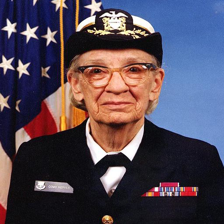

In [3]:
test_image = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
test_image = Image.open(test_image).resize((IMAGE_RES, IMAGE_RES))
test_image

In [4]:
test_image = np.array(test_image)/255.0
test_image.shape

(224, 224, 3)

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [5]:
result = model.predict(test_image[np.newaxis, ...])
result.shape

predicted_class = np.argmax(result[0], axis=-1)
predicted_class

1/1 [==============================] - 2s 2s/step


653

To see what the model predicted for test_image we need the ImageNet label and fetch the row that the model predicted

10484/10484 [==============================] - 0s 1us/step


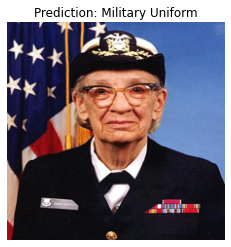

In [6]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(test_image)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Using a TensorFlow Hub model for the Cats vs. Dogs dataset



### Get the dataset 

We can use the TensorFlow Datasets to load the Dogs vs. Cats dataset.

In [7]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info = True, 
    as_supervised = True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete667JXG/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


As we know, the images on the dataset are not all the same size, and we need them to be 244 x 244 px because that is what the ImageNet model needs as inputs.

So therefore, we need to format the images

In [8]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

BATCH_SIZE = 32 

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

### Run the classifier on a batch of images

ImageNet classifier has a great amount o images of dogs and cats, but let's see how it improves before transfer learning.

In [9]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 955ms/step


array(['tiger cat', 'dalmatian', 'Egyptian cat', 'Siamese cat', 'lynx',
       'Lhasa', 'space heater', 'American Staffordshire terrier',
       'Egyptian cat', 'Staffordshire bullterrier', 'tabby',
       'Labrador retriever', 'tabby', 'Egyptian cat', 'tabby',
       'tiger cat', 'flat-coated retriever', 'Staffordshire bullterrier',
       'pug', 'basenji', 'kelpie', 'beagle', 'Great Dane', 'tabby',
       'golden retriever', 'Chesapeake Bay retriever', 'Egyptian cat',
       'Egyptian cat', 'chow', 'siamang', 'Egyptian cat', 'lynx'],
      dtype='<U30')

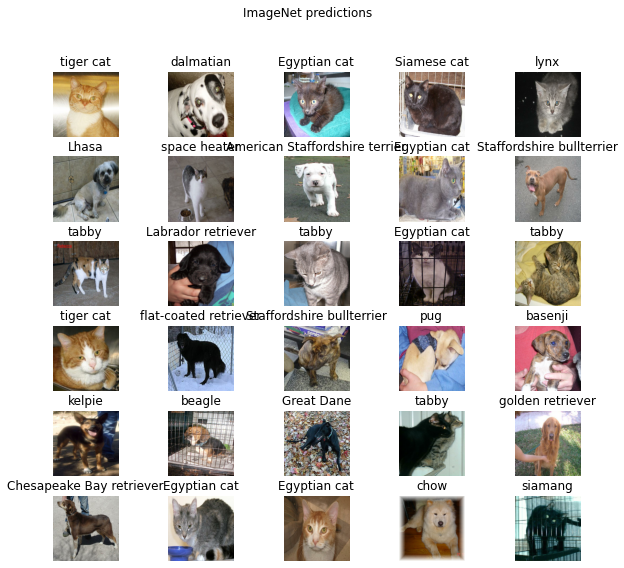

In [10]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Do a simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [11]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor = hub.KerasLayer(
    URL,
    input_shape = (IMAGE_RES, IMAGE_RES,3)
)

32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [12]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer

In [13]:
feature_extractor.trainable = False

Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

In [14]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model


In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

EPOCHS = 2

history = model.fit(
    train_batches,
    epochs = EPOCHS,
    validation_data = validation_batches
)

Epoch 1/2
582/582 [==============================] - 756s 1s/step - loss: 0.0304 - accuracy: 0.9896 - val_loss: 0.0298 - val_accuracy: 0.9905
Epoch 2/2
582/582 [==============================] - 737s 1s/step - loss: 0.0260 - accuracy: 0.9913 - val_loss: 0.0445 - val_accuracy: 0.9845


Let's plot the training and validation accuracy/loss graphs.

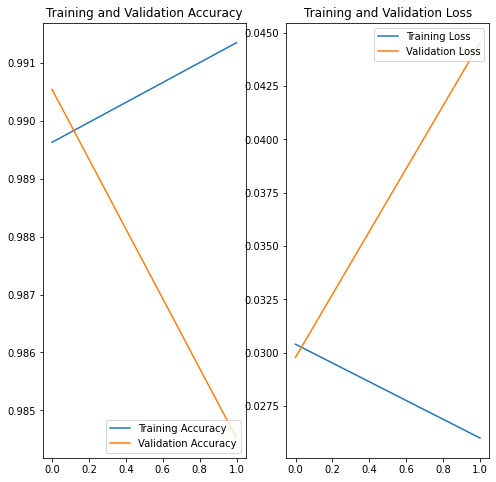

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

### Check the predictions


In [18]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [19]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 2s 2s/step


array(['cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat',
       'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog',
       'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat',
       'cat', 'dog', 'cat', 'cat', 'cat'], dtype='<U3')

In [20]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0]
Predicted labels:  [0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0]


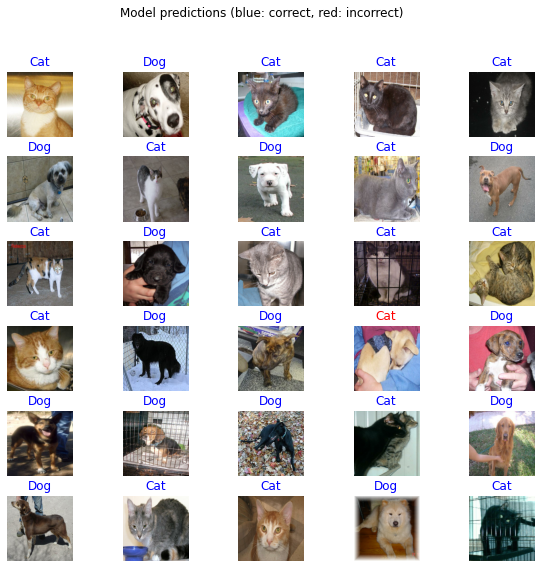

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

https://towardsdatascience.com/understanding-your-convolution-network-with-visualizations-a4883441533b